# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


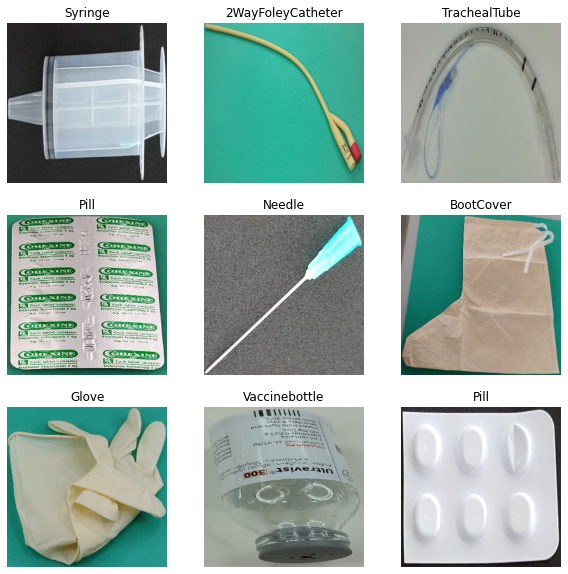

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/'

In [22]:
EPOCHS = 4000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/4000
49/49 [==============================] - 43s 338ms/step - loss: 1.8587 - accuracy: 0.5363 - val_loss: 0.9494 - val_accuracy: 0.7451
Epoch 2/4000
49/49 [==============================] - 9s 184ms/step - loss: 0.6486 - accuracy: 0.8591 - val_loss: 0.5634 - val_accuracy: 0.8745
Epoch 3/4000
49/49 [==============================] - 9s 184ms/step - loss: 0.3927 - accuracy: 0.9283 - val_loss: 0.4229 - val_accuracy: 0.9094
Epoch 4/4000
49/49 [==============================] - 9s 184ms/step - loss: 0.2793 - accuracy: 0.9554 - val_loss: 0.3468 - val_accuracy: 0.9237
Epoch 5/4000
49/49 [==============================] - 9s 184ms/step - loss: 0.2136 - accuracy: 0.9693 - val_loss: 0.2979 - val_accuracy: 0.9327
Epoch 6/4000
49/49 [==============================] - 9s 181ms/step - loss: 0.1702 - accuracy: 0.9771 - val_loss: 0.2642 - val_accuracy: 0.9483
Epoch 7/4000
49/49 [==============================] - 9s 181ms/step - loss: 0.1398 - accuracy: 0.9832 - val_loss: 0.2397 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

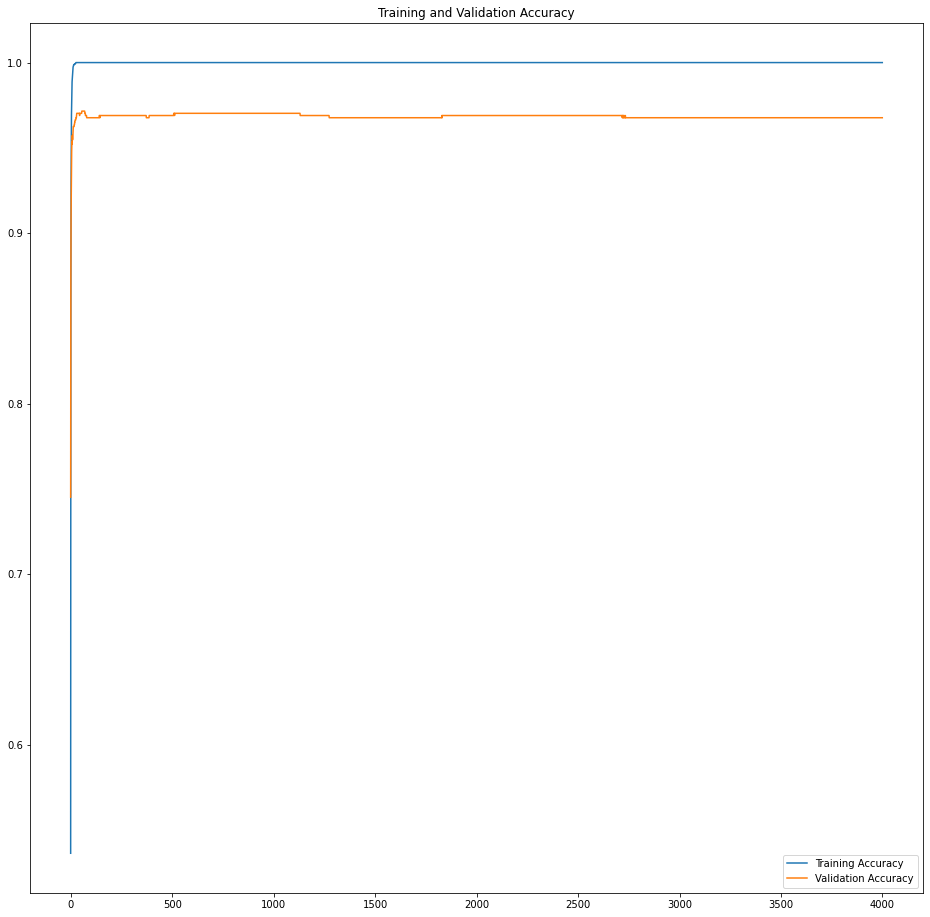

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


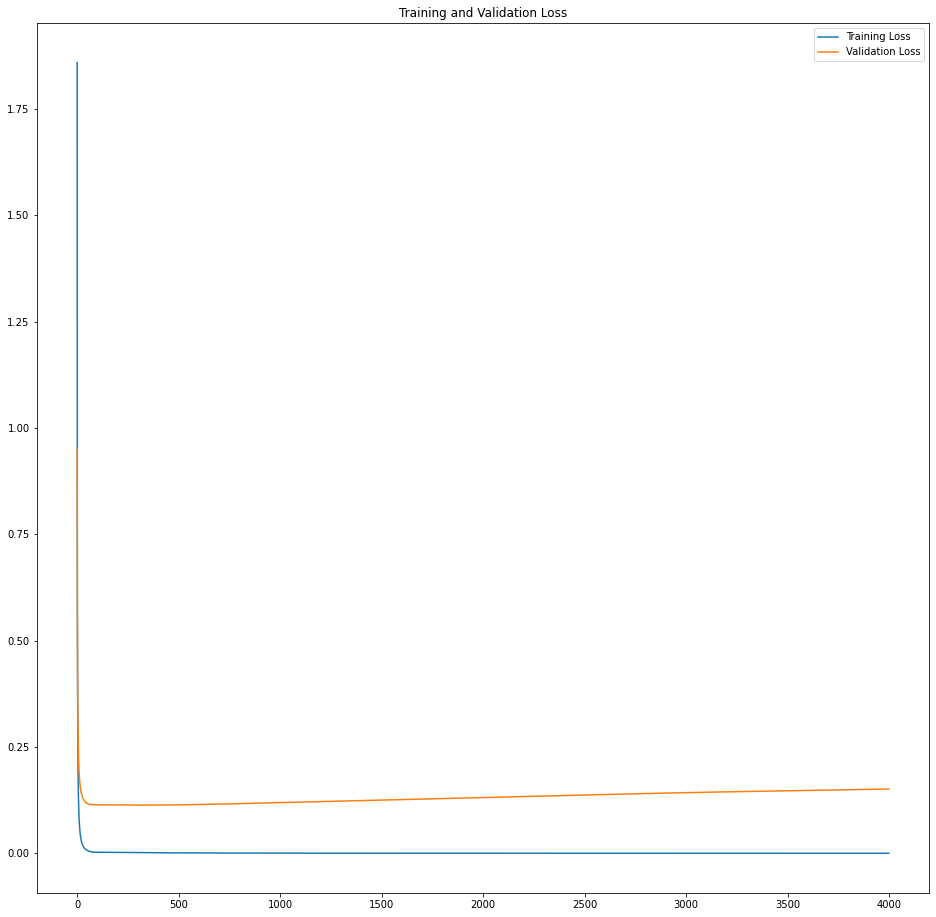

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 346ms/step - loss: 0.7687 - accuracy: 0.8523
test_indoor_ds_results:test loss, test acc: [0.7687352299690247, 0.8522853851318359]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 25s 425ms/step - loss: 2.1009 - accuracy: 0.7382
test_outdoor_ds_results:test loss, test acc: [2.1008732318878174, 0.7382165789604187]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 206ms/step - loss: 2.3062 - accuracy: 0.6859
test_belt_ds_results:test loss, test acc: [2.3062143325805664, 0.6858567595481873]


In [28]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAu

# Testing in testset

In [29]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 140ms/step - loss: 1.3339 - accuracy: 0.6627
Epoch040 
 test_indoor_acc=0.8322185277938843 
 test_outdoor_acc=0.7321656346321106 
 test_belt_acc=0.6627379655838013
35/35 [==============================] - 5s 140ms/step - loss: 1.4529 - accuracy: 0.6659
Epoch080 
 test_indoor_acc=0.8422519564628601 
 test_outdoor_acc=0.737261176109314 
 test_belt_acc=0.6659111380577087
35/35 [==============================] - 5s 139ms/step - loss: 1.4557 - accuracy: 0.6664
Epoch120 
 test_indoor_acc=0.843366801738739 
 test_outdoor_acc=0.7375796437263489 
 test_belt_acc=0.6663644313812256
35/35 [==============================] - 5s 140ms/step - loss: 1.4597 - accuracy: 0.6668
Epoch160 
 test_indoor_acc=0.8439241647720337 
 test_outdoor_acc=0.7382165789604187 
 test_belt_acc=0.6668177843093872
35/35 [==============================] - 5s 140ms/step - loss: 1.4683 - accuracy: 0.6677
Epoch200 
 test_indoor_acc=0.8444815874099731 
 test_outdoor_acc=0.73821657896041

In [38]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)

range(40, 4040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

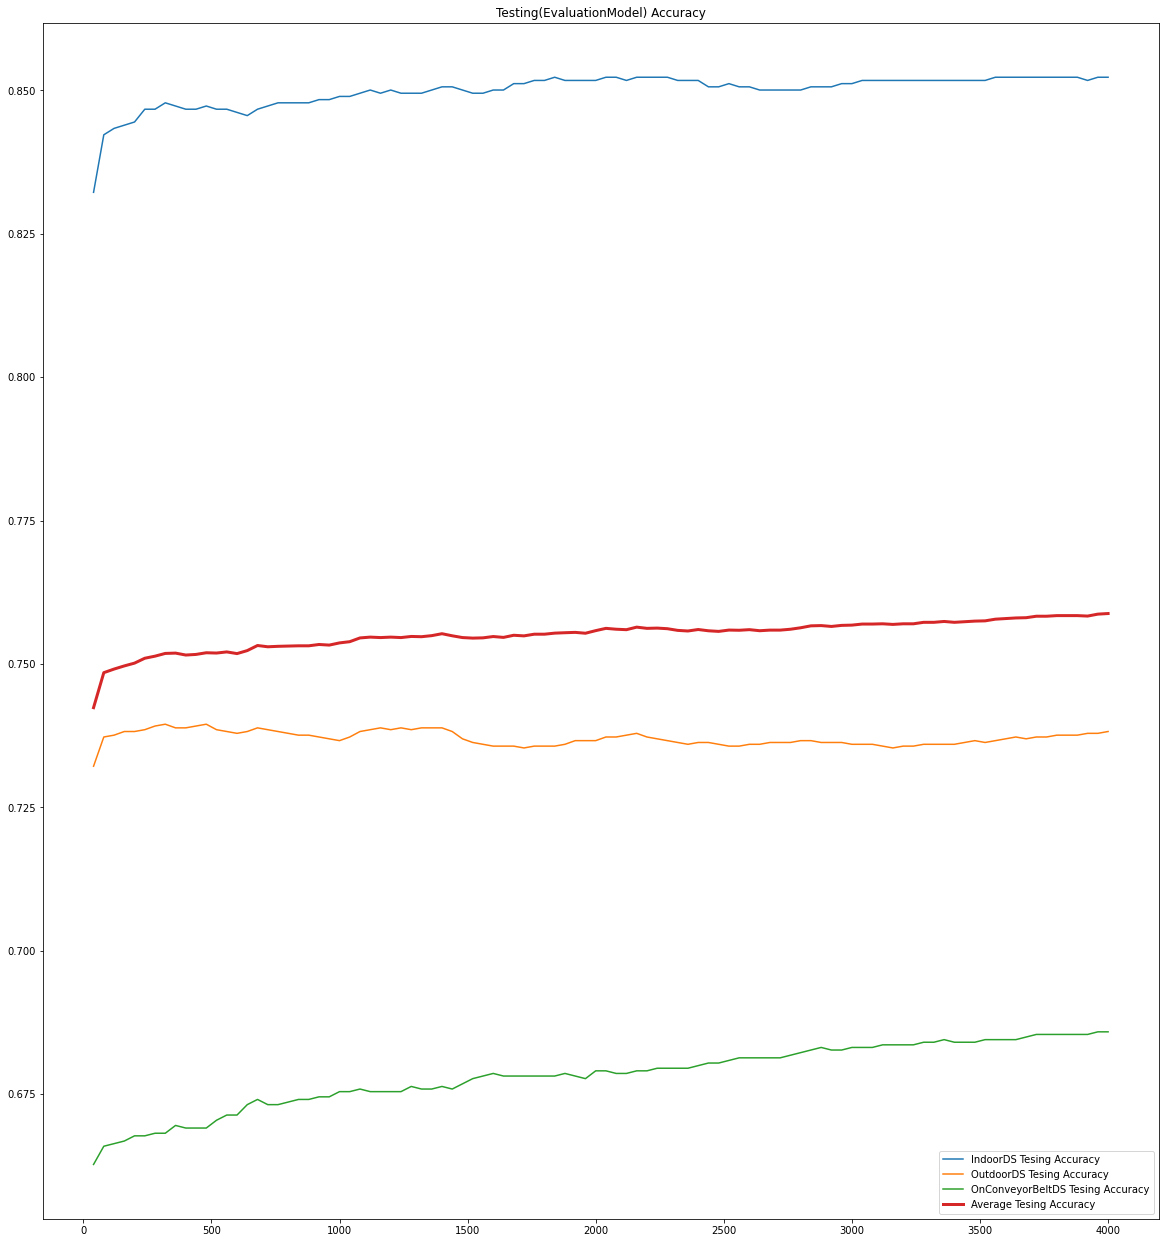

In [39]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [40]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7587862412134806
max index -> 99
The [Epoch] of max acc -> 4000


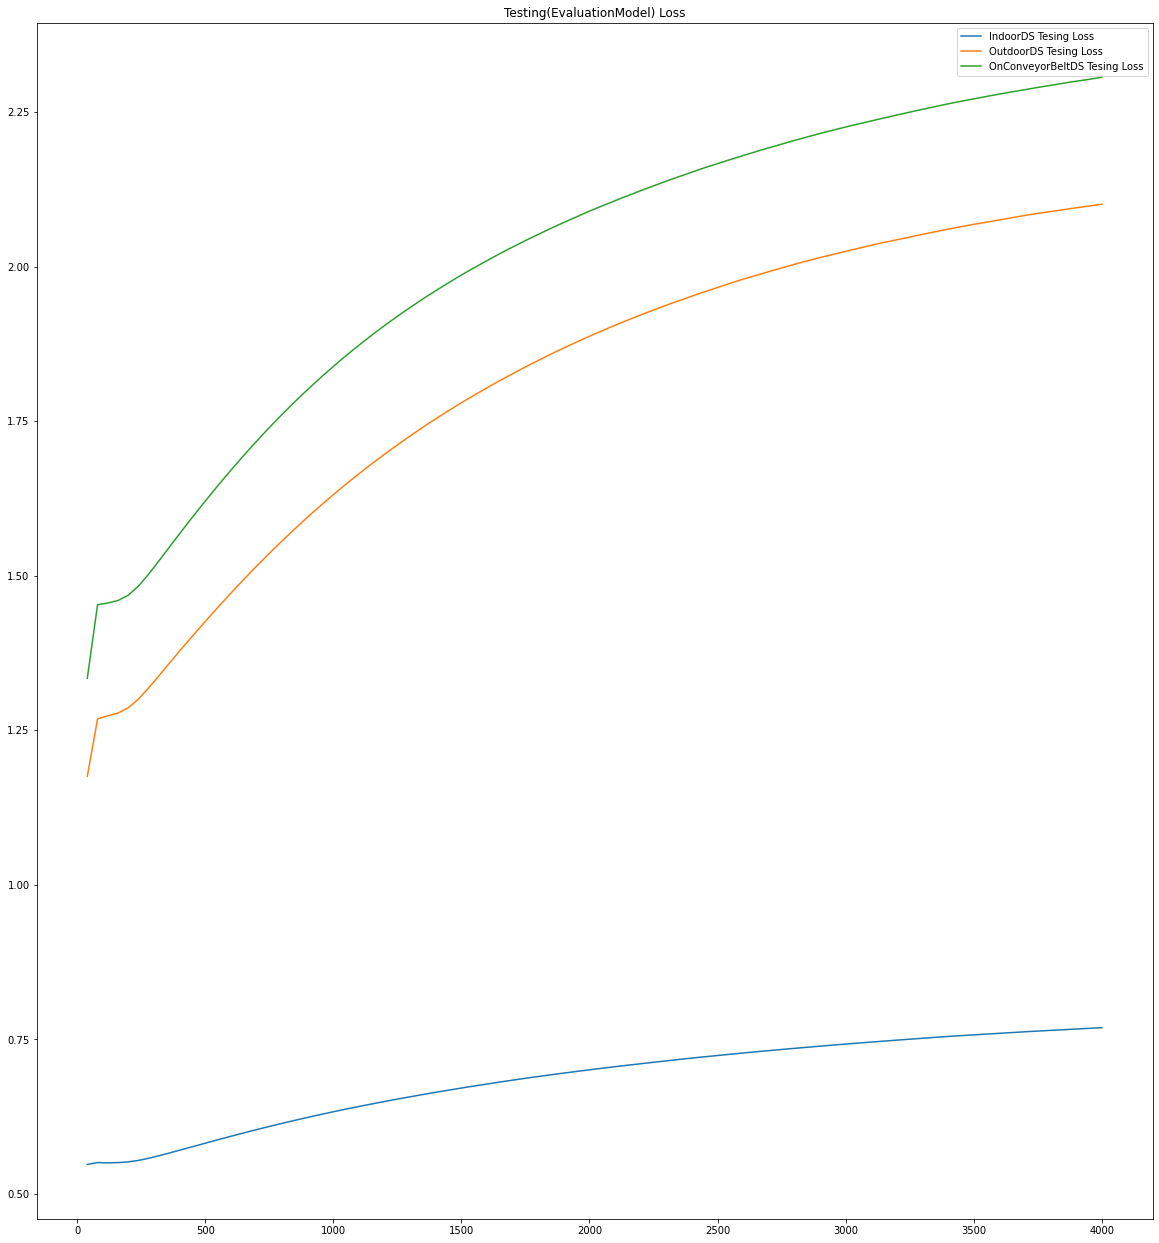

In [31]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [32]:
test_indoor_acc

[0.8322185277938843,
 0.8422519564628601,
 0.843366801738739,
 0.8439241647720337,
 0.8444815874099731,
 0.846711277961731,
 0.846711277961731,
 0.8478260636329651,
 0.8472687005996704,
 0.846711277961731,
 0.846711277961731,
 0.8472687005996704,
 0.846711277961731,
 0.846711277961731,
 0.8461538553237915,
 0.845596432685852,
 0.846711277961731,
 0.8472687005996704,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8478260636329651,
 0.8483834862709045,
 0.8483834862709045,
 0.848940908908844,
 0.848940908908844,
 0.8494983315467834,
 0.8500557541847229,
 0.8494983315467834,
 0.8500557541847229,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.8500557541847229,
 0.8506131768226624,
 0.8506131768226624,
 0.8500557541847229,
 0.8494983315467834,
 0.8494983315467834,
 0.8500557541847229,
 0.8500557541847229,
 0.851170539855957,
 0.851170539855957,
 0.8517279624938965,
 0.8517279624938965,
 0.8522853851318359,
 0.8517279624938965,
 0.8517279624938965,
 0.85

In [33]:
test_outdoor_acc

[0.7321656346321106,
 0.737261176109314,
 0.7375796437263489,
 0.7382165789604187,
 0.7382165789604187,
 0.7385350465774536,
 0.7391719818115234,
 0.7394904494285583,
 0.7388535141944885,
 0.7388535141944885,
 0.7391719818115234,
 0.7394904494285583,
 0.7385350465774536,
 0.7382165789604187,
 0.7378981113433838,
 0.7382165789604187,
 0.7388535141944885,
 0.7385350465774536,
 0.7382165789604187,
 0.7378981113433838,
 0.7375796437263489,
 0.7375796437263489,
 0.737261176109314,
 0.7369426488876343,
 0.7366241812705994,
 0.737261176109314,
 0.7382165789604187,
 0.7385350465774536,
 0.7388535141944885,
 0.7385350465774536,
 0.7388535141944885,
 0.7385350465774536,
 0.7388535141944885,
 0.7388535141944885,
 0.7388535141944885,
 0.7382165789604187,
 0.7369426488876343,
 0.7363057136535645,
 0.7359872460365295,
 0.7356687784194946,
 0.7356687784194946,
 0.7356687784194946,
 0.7353503108024597,
 0.7356687784194946,
 0.7356687784194946,
 0.7356687784194946,
 0.7359872460365295,
 0.7366241812705

In [34]:
test_belt_acc

[0.6627379655838013,
 0.6659111380577087,
 0.6663644313812256,
 0.6668177843093872,
 0.6677243709564209,
 0.6677243709564209,
 0.6681777238845825,
 0.6681777238845825,
 0.6695376038551331,
 0.6690843105316162,
 0.6690843105316162,
 0.6690843105316162,
 0.6704442501068115,
 0.6713508367538452,
 0.6713508367538452,
 0.6731640696525574,
 0.6740707159042358,
 0.6731640696525574,
 0.6731640696525574,
 0.673617422580719,
 0.6740707159042358,
 0.6740707159042358,
 0.6745240092277527,
 0.6745240092277527,
 0.6754306554794312,
 0.6754306554794312,
 0.675883948802948,
 0.6754306554794312,
 0.6754306554794312,
 0.6754306554794312,
 0.6754306554794312,
 0.6763372421264648,
 0.675883948802948,
 0.675883948802948,
 0.6763372421264648,
 0.675883948802948,
 0.6767905950546265,
 0.6776971817016602,
 0.678150475025177,
 0.6786038279533386,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.678150475025177,
 0.6786038279533386,
 0.678150475025177,
 0.67

In [35]:
test_indoor_loss

[0.5474521517753601,
 0.5505087971687317,
 0.5499758124351501,
 0.5504218935966492,
 0.5516318082809448,
 0.5539655685424805,
 0.5574705600738525,
 0.56156325340271,
 0.5659325122833252,
 0.5704522132873535,
 0.5749630928039551,
 0.5794882774353027,
 0.584009051322937,
 0.5885311365127563,
 0.5929408669471741,
 0.5972937941551208,
 0.6015905737876892,
 0.6057882308959961,
 0.6098875999450684,
 0.6139073967933655,
 0.6178085803985596,
 0.6216400861740112,
 0.6253940463066101,
 0.6290615200996399,
 0.6326103806495667,
 0.6361170411109924,
 0.6395156383514404,
 0.6428380012512207,
 0.6460497975349426,
 0.6492317318916321,
 0.6523626446723938,
 0.6554012298583984,
 0.6583667993545532,
 0.6612713932991028,
 0.6641625761985779,
 0.6669111251831055,
 0.6696622967720032,
 0.6724257469177246,
 0.6749745011329651,
 0.6775418519973755,
 0.6800705790519714,
 0.6825801730155945,
 0.6849812865257263,
 0.6873977780342102,
 0.6896379590034485,
 0.6919407248497009,
 0.6941441297531128,
 0.6963225007057

In [36]:
test_outdoor_loss

[1.1754167079925537,
 1.2680537700653076,
 1.2732489109039307,
 1.277627944946289,
 1.2863084077835083,
 1.3004531860351562,
 1.318543791770935,
 1.338171362876892,
 1.3580996990203857,
 1.3777905702590942,
 1.3972249031066895,
 1.416276454925537,
 1.4350007772445679,
 1.453425407409668,
 1.4714453220367432,
 1.4891254901885986,
 1.5064524412155151,
 1.5232969522476196,
 1.5399068593978882,
 1.556013822555542,
 1.5717533826828003,
 1.5870873928070068,
 1.602067232131958,
 1.6166679859161377,
 1.6308462619781494,
 1.6447110176086426,
 1.6580851078033447,
 1.6711747646331787,
 1.683921217918396,
 1.6962578296661377,
 1.7084153890609741,
 1.7201648950576782,
 1.7315852642059326,
 1.7428550720214844,
 1.753672480583191,
 1.7642745971679688,
 1.7745095491409302,
 1.7845845222473145,
 1.7942215204238892,
 1.8037488460540771,
 1.8131115436553955,
 1.8221603631973267,
 1.8309848308563232,
 1.839678406715393,
 1.8480167388916016,
 1.856288194656372,
 1.8644018173217773,
 1.8721227645874023,
 1.

In [37]:
test_belt_loss

[1.3339065313339233,
 1.4528872966766357,
 1.4556704759597778,
 1.4597371816635132,
 1.468339443206787,
 1.483149528503418,
 1.5027031898498535,
 1.5240930318832397,
 1.545964241027832,
 1.5676610469818115,
 1.5890522003173828,
 1.6100293397903442,
 1.630578875541687,
 1.6507017612457275,
 1.6702628135681152,
 1.689373254776001,
 1.70797860622406,
 1.7261074781417847,
 1.7436566352844238,
 1.7606390714645386,
 1.7772233486175537,
 1.793212652206421,
 1.8087289333343506,
 1.8237383365631104,
 1.838217854499817,
 1.8524359464645386,
 1.8660216331481934,
 1.879202127456665,
 1.892080307006836,
 1.904421091079712,
 1.9164271354675293,
 1.928068995475769,
 1.9393469095230103,
 1.9503265619277954,
 1.9608354568481445,
 1.9712144136428833,
 1.9812484979629517,
 1.991081714630127,
 2.000317335128784,
 2.0095179080963135,
 2.0185368061065674,
 2.027374505996704,
 2.0357048511505127,
 2.0440673828125,
 2.0519564151763916,
 2.059830904006958,
 2.067559242248535,
 2.075026512145996,
 2.08224105834

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch4000-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

N = 100

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)} are predicting")
x_indoor_sets = np.array_split(x_test_indoor, N)
del x_test_indoor
y_all_sets_predicted = []
for x in x_indoor_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_indoor_predicted = np.concatenate(y_all_sets_predicted)
del x_indoor_sets,test_indoor_ds

x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)} are predicting")
x_outdoor_sets = np.array_split(x_test_outdoor, N)
del x_test_outdoor
y_all_sets_predicted = []
for x in x_outdoor_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_outdoor_predicted = np.concatenate(y_all_sets_predicted)
del x_outdoor_sets,test_outdoor_ds

x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)} are predicting")
x_belt_sets = np.array_split(x_test_belt, N)
del x_test_belt
y_all_sets_predicted = []
for x in x_belt_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_belt_predicted = np.concatenate(y_all_sets_predicted)
del x_belt_sets,test_belt_ds

y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
y_all_predicted = np.concatenate([y_indoor_predicted,y_outdoor_predicted,y_belt_predicted],axis=0)
print(f"all num x,y :{len(y_all_predicted)},{len(y_all)}")

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794 are predicting
train_outdoor num x,y : 3140,3140 are predicting
train_belt num x,y : 2206,2206 are predicting
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5360
FP=1780
acc=0.7507002801120448
all check = 7140


In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 72.41379310344827%
2WayConnectorforFoley acc = 90.47619047619048%
2WayFoleyCatheter acc = 72.38805970149254%
3WayConnectorforFoley acc = 95.72649572649573%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 44.44444444444444%
BootCover acc = 65.66265060240963%
CottonBall acc = 73.65269461077844%
CottonSwap acc = 77.62237762237763%
Dilator acc = 72.64957264957265%
DisposableInfusionSet acc = 55.75221238938053%
ExtensionTube acc = 39.02439024390244%
FaceShield acc = 69.75308641975309%
FrontLoadSyringe acc = 54.86725663716814%
GauzePad acc = 60.79545454545454%
Glove acc = 75.0%
GuideWire acc = 32.142857142857146%
LiquidBottle acc = 63.358778625954194%
Mask acc = 94.02597402597402%
NGTube acc = 45.16129032258064%
NasalCannula acc = 68.14159292035397%
Needle acc = 81.07142857142857%
OxygenMask acc = 97.74436090225564%
PPESuit acc = 95.16129032258065%
PharmaceuticalProduct acc = 63.084112149532714%
Pill acc = 96.9187675070028%
PillB

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 84,   0,   0, ...,   0,   1,   0],
       [  0, 133,   0, ...,   0,   0,   0],
       [  0,   0,  97, ...,   0,   3,   6],
       ...,
       [  0,   0,   0, ...,  71,   1,   1],
       [  0,   0,   0, ...,   0, 180,   0],
       [  0,   1,   0, ...,   0,   2,  77]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[72.4137931 ,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.        , 90.47619048,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 72.3880597 , ...,  0.        ,
         2.23880597,  4.47761194],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 59.16666667,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        84.50704225,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.        ,
         1.75438596, 67.54385965]])

<AxesSubplot:>

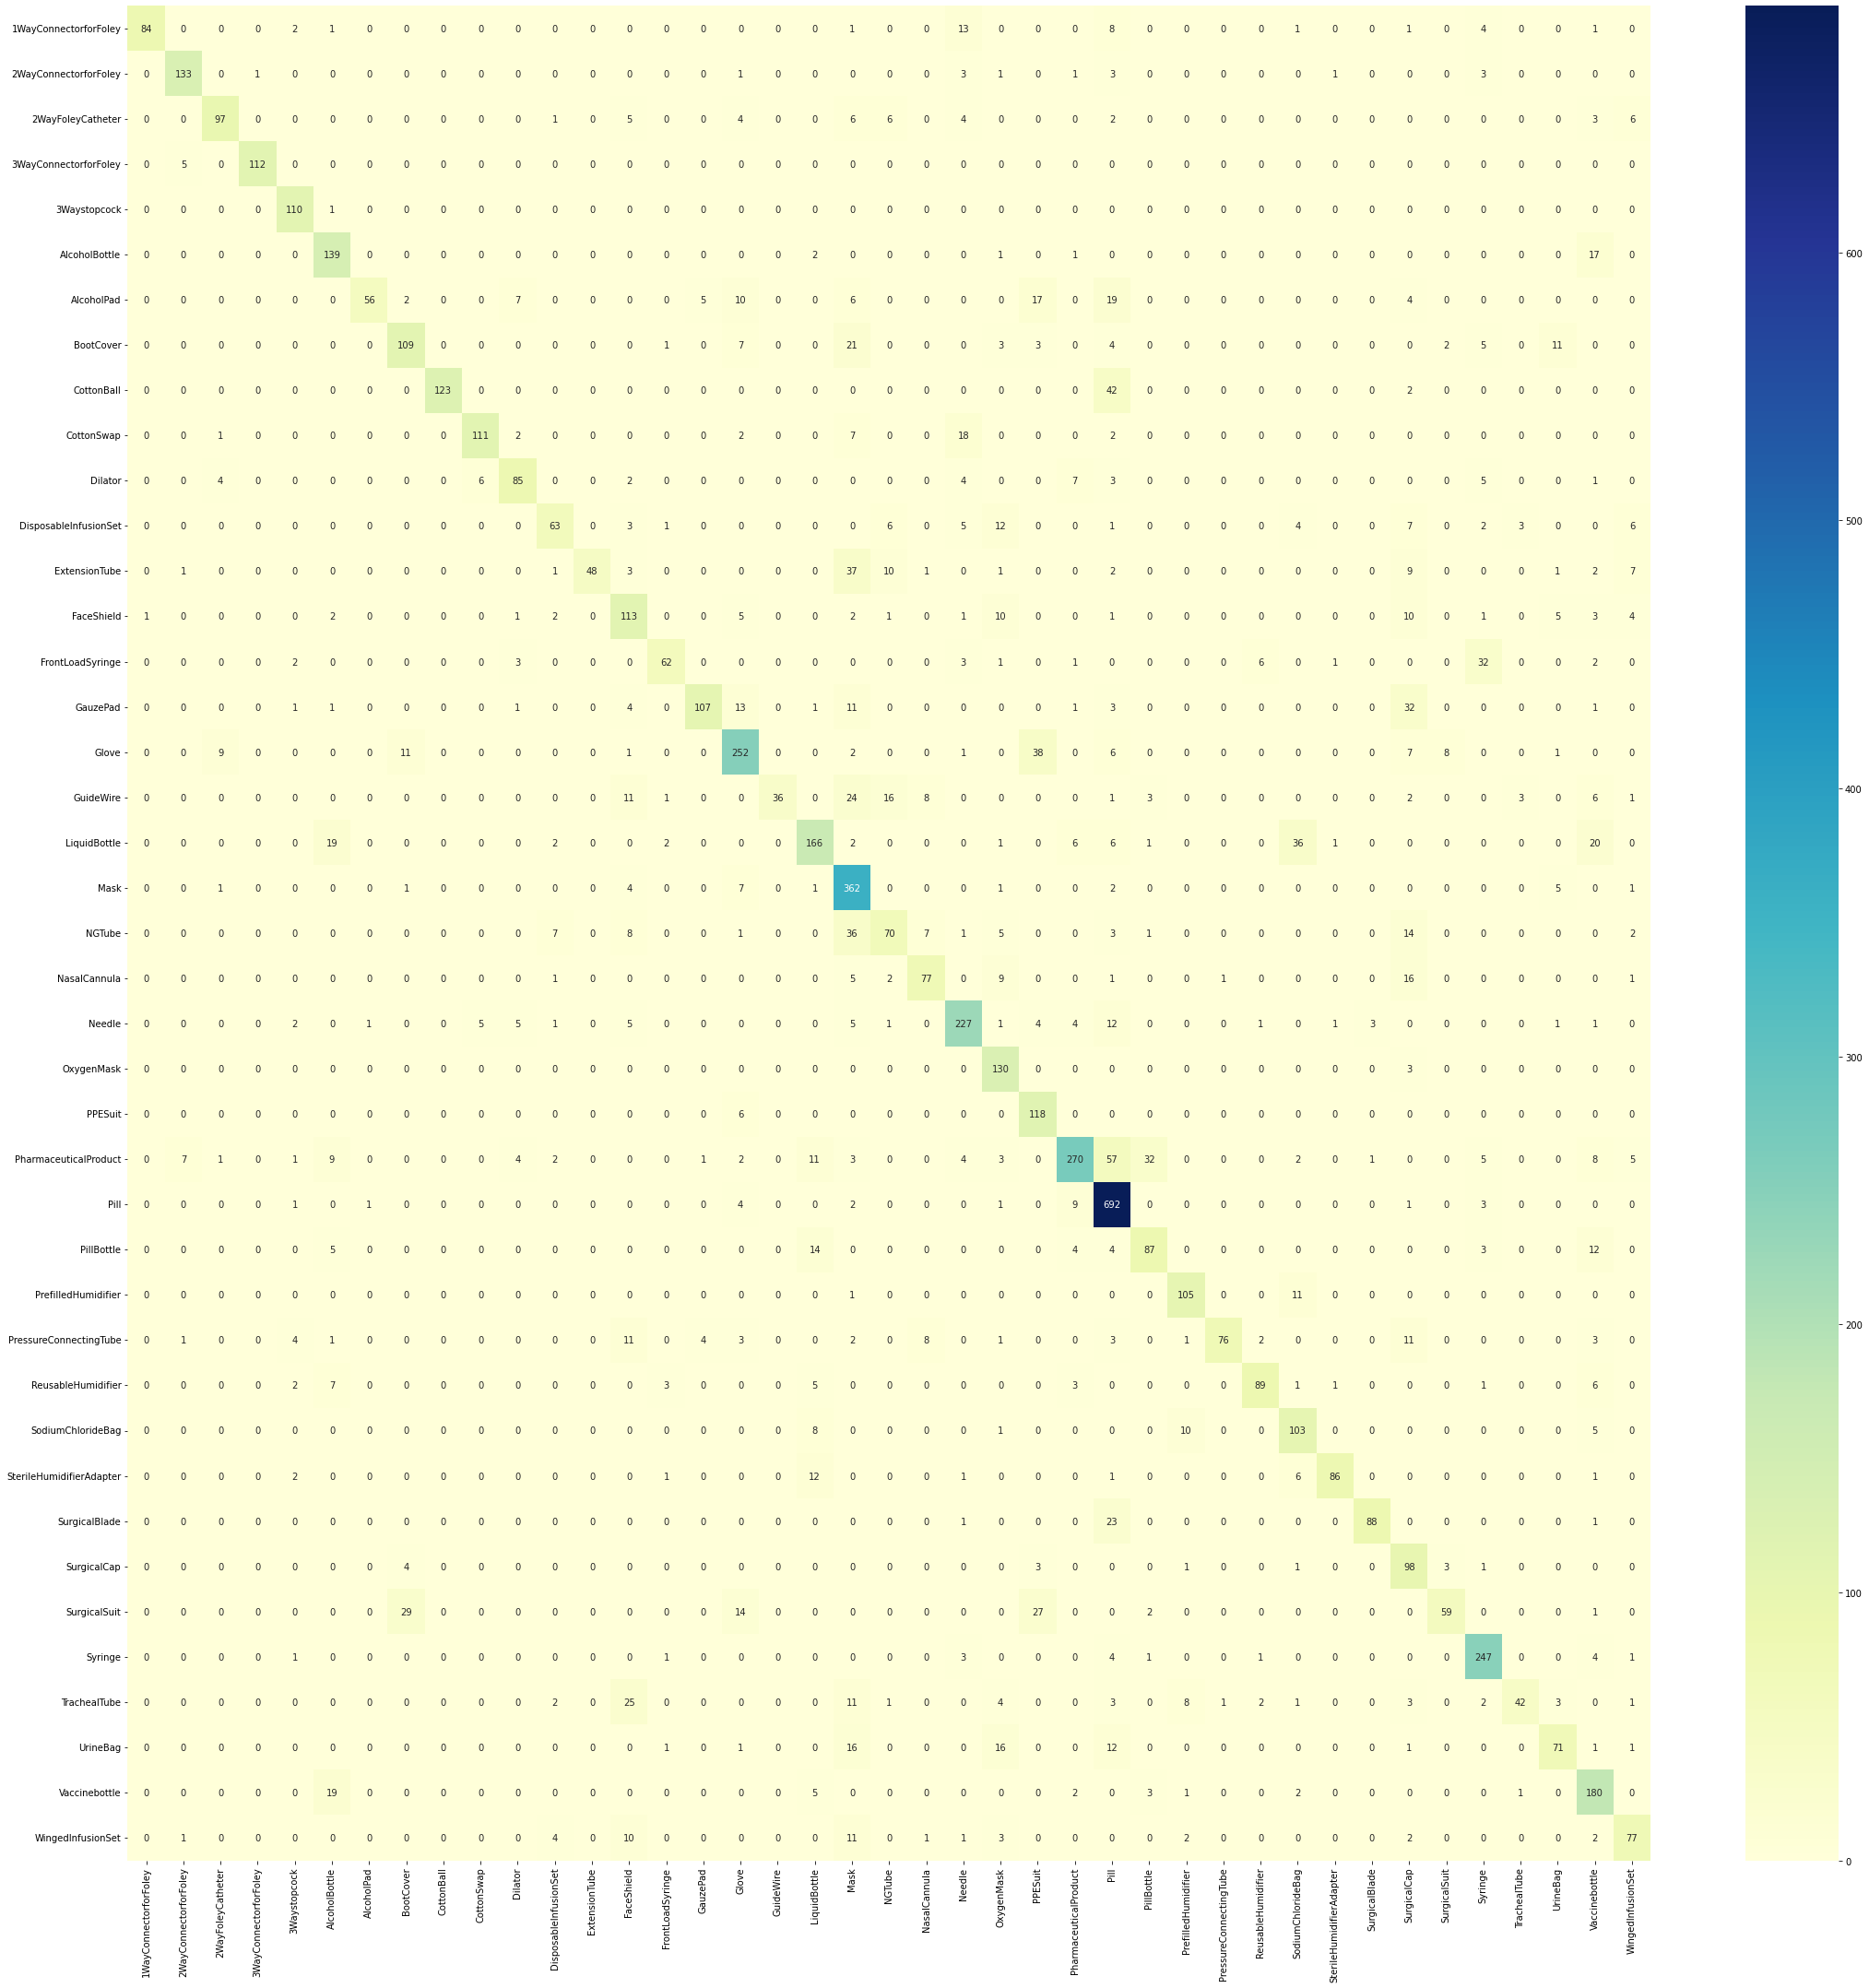

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

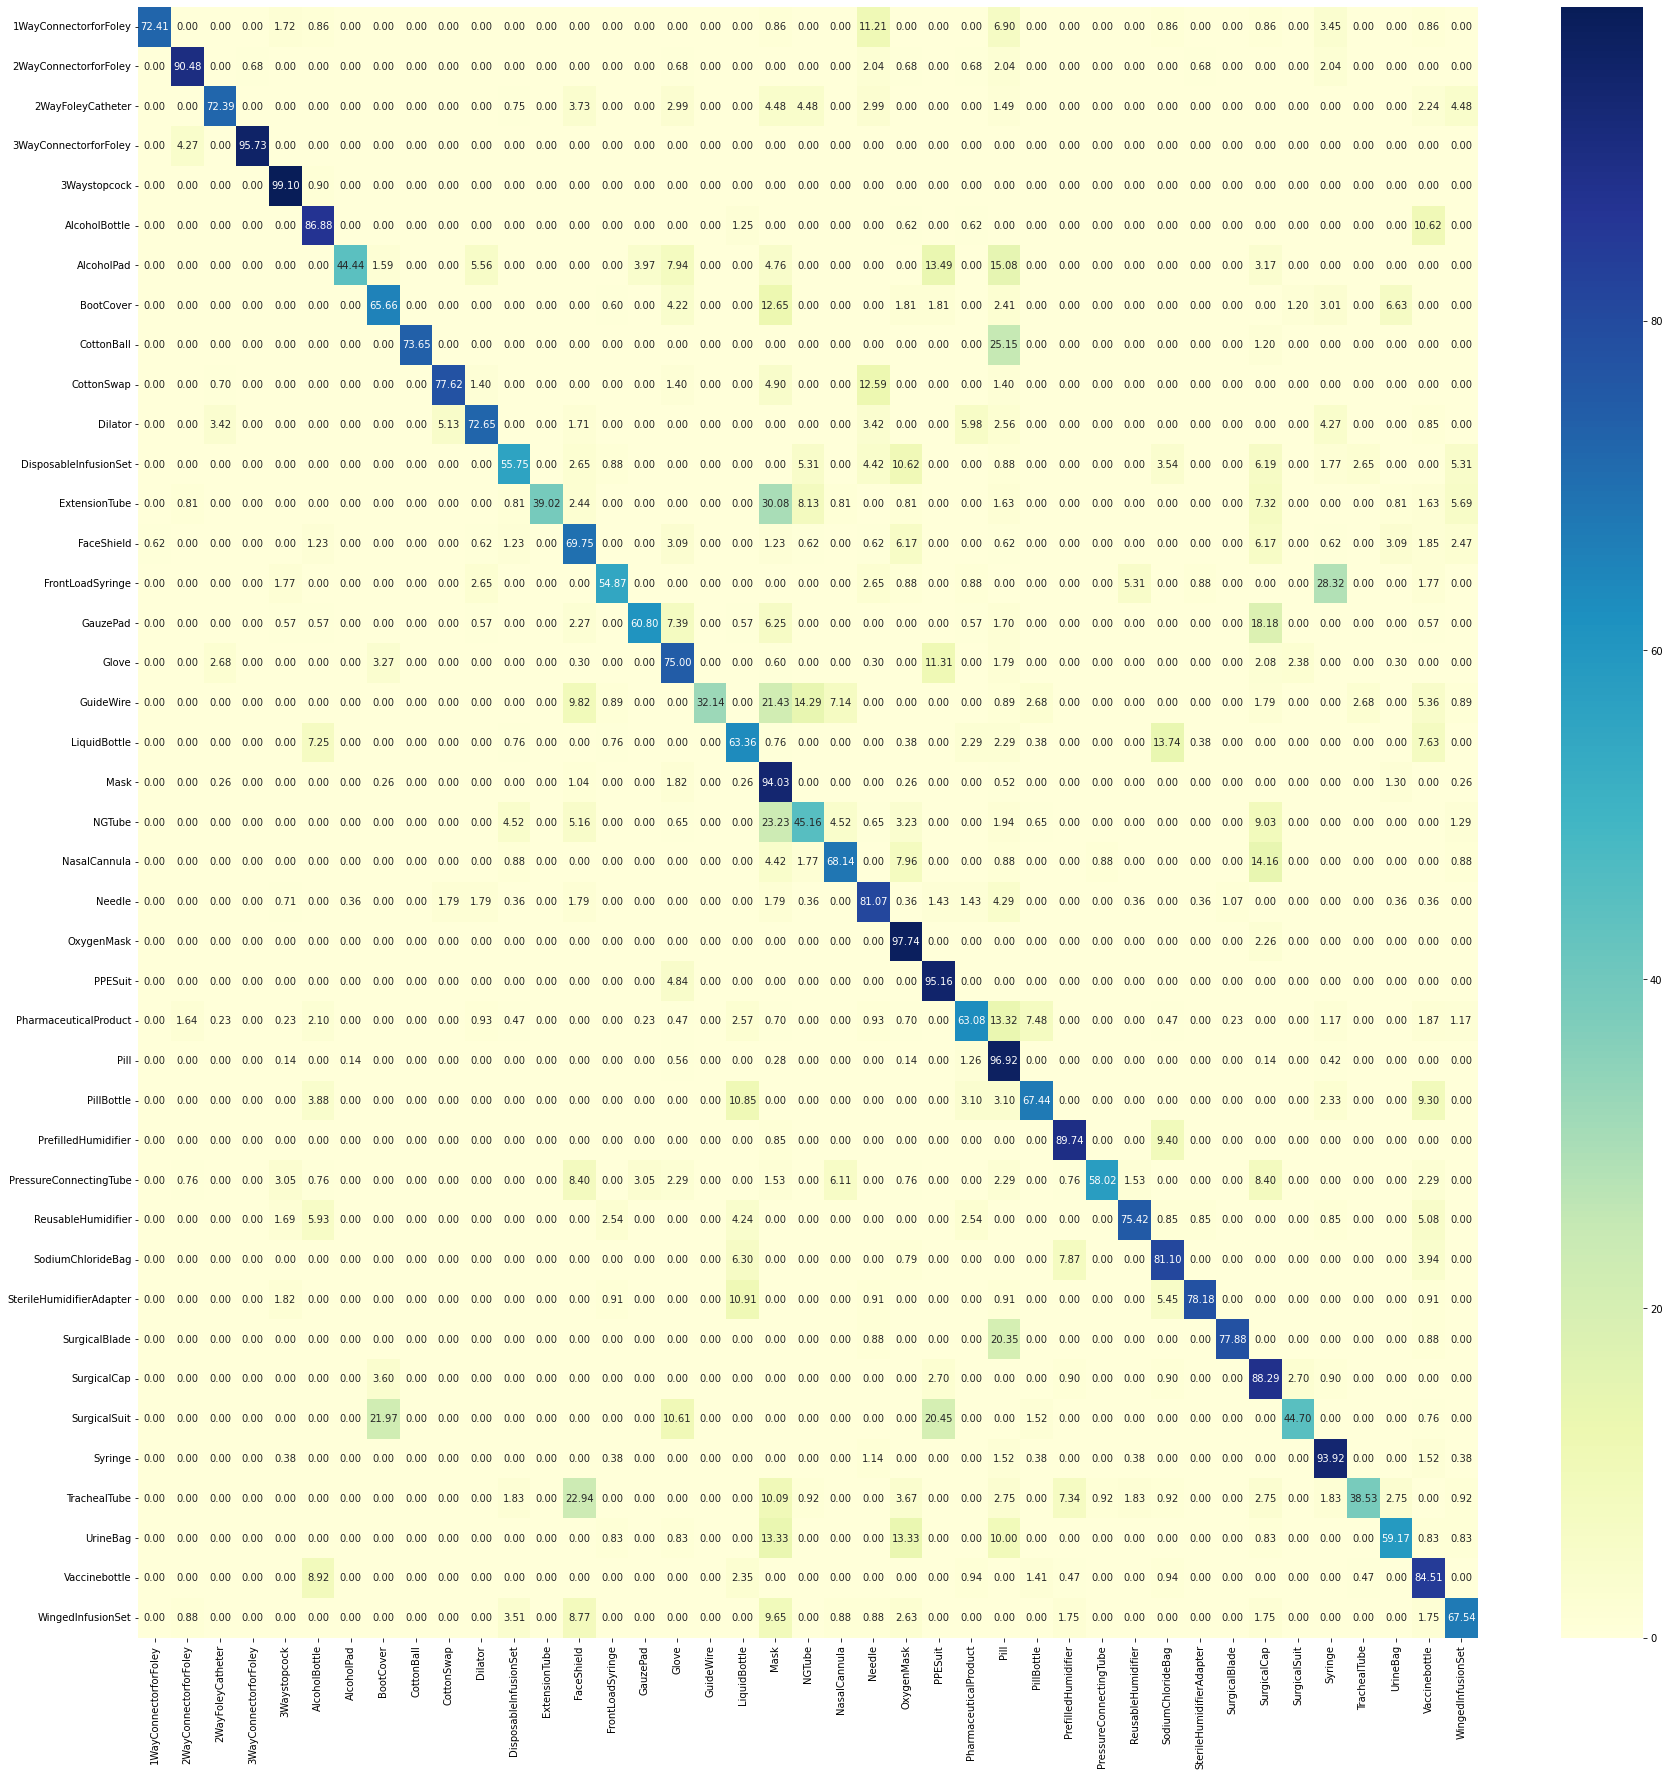

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")